In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install scikit-learn
!pip install openpyxl

Vorm van de data: (139, 494)
Kolommen: ['PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_rad_dist_avg_2.5D', 'PREDICT_original_sf_rad_dist_std_2.5D', 'PREDICT_original_sf_roughness_avg_2.5D', 'PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_cvar_avg_2.5D', 'PREDICT_original_sf_cvar_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_sf_evar_avg_2.5D', 'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_solidity_avg_2.5D', 'PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D', 'PREDICT_original_of_theta_x', 'PREDICT_original_of_theta_y', 'PREDICT_original_of_theta_z', 'PREDICT_original_hf_min', 'PREDICT_origin

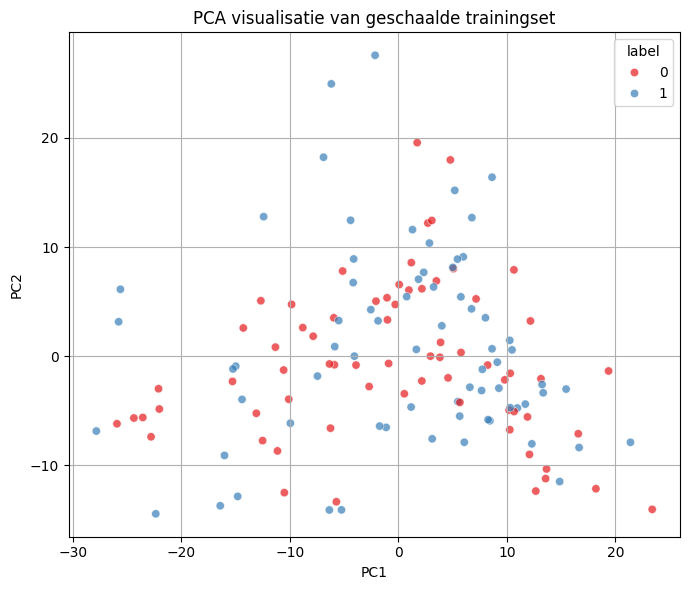

In [ ]:
# 📦 Vereiste imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🧾 Stap 1 – Laad de data
data = pd.read_excel(".\TrainData.xlsx")

# 🔍 Eerste inspectie
print("Vorm van de data:", data.shape)
print("Kolommen:", data.columns.tolist())
print("Aantal duplicaten:", data.duplicated().sum())
print("Missende waarden per kolom:")
print(data.isnull().sum())

# 🧼 Stap 2 – Dubbele rijen verwijderen
data = data.drop_duplicates()

# 🎯 Stap 3 – Split in features en labels
X = data.drop(columns="label")
y = data["label"]

# 🔁 Zet y om naar numeriek met behoud van pandas Series
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(y), index=y.index)

# ❓ Hoeveel missende waarden blijven over?
print("Totaal aantal missende waarden:", X.isnull().sum().sum())

# ⚠️ Stap 4 – NaNs imputer (mediaan)
X = X.fillna(X.median(numeric_only=True))

# # 📏 Stap 5 – Train-test split (eerlijk en met stratificatie)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25,
#     stratify=y,
#     random_state=42
# )

# print("Aantal training samples:", len(X_train))
# print("Aantal training labels:", len(y_train))
# print("Aantal test samples:", len(X_test))
# print("Aantal test labels:", len(y_test))

# 📊 Evaluatie via meerdere metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# 🔁 Vergelijking van scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, scaler in scalers.items():
    X_scaled_tmp = scaler.fit_transform(X)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_validate(model, X_scaled_tmp, y, cv=cv, scoring=scoring)

    results[name] = {
        'mean_accuracy': np.mean(scores['test_accuracy']),
        'mean_f1': np.mean(scores['test_f1']),
        'mean_auc': np.mean(scores['test_roc_auc'])
    }

# 📋 Print overzicht
print("\n🔍 Vergelijking van scalers op basis van Accuracy, F1 en ROC AUC:")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['mean_accuracy']:.3f}, "
          f"F1 = {res['mean_f1']:.3f}, "
          f"AUC = {res['mean_auc']:.3f}")

# ✅ Beste scaler kiezen op basis van AUC (pas dit aan naar 'mean_f1' of 'mean_accuracy' indien gewenst)
best_scaler_name = max(results.items(), key=lambda x: x[1]['mean_auc'])[0]
print(f"\n✅ Beste scaler op basis van AUC: {best_scaler_name}")

# 🔁 Gebruik de beste scaler voor de rest van de pipeline
scaler = scalers[best_scaler_name]
X_scaled = scaler.fit_transform(X)

## tot hier pre-processing

## vanaf hier data visualisatie

# ⚖️ Stap 6 – Balans controleren
print("\nLabelverdeling in training set:\n", y.value_counts(normalize=True))

# 📉 Stap 7 – PCA visualisatie 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = y.values  # y_train is een Series, dus .values werkt nu

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7)
plt.title("PCA visualisatie van geschaalde trainingset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# # 📌 Stap 8 – Univariate feature selectie
# selector = SelectKBest(score_func=f_classif, k=10)
# X_kbest = selector.fit_transform(X_train_scaled, y_train)
# selected_kbest = X_train.columns[selector.get_support()]
# print("Top 10 features volgens SelectKBest:", selected_kbest.tolist())

# # 🌳 Stap 9 – Random Forest Feature Importances
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X_train_scaled, y_train)
# importances = pd.Series(rf.feature_importances_, index=X_train.columns)
# top_features = importances.sort_values(ascending=False).head(10)
# print("Top 10 belangrijke features volgens RF:\n", top_features)

# 🔁 Stap 10 – RFECV (wrapper methode)
#rfecv = RFECV(
#    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
#    step=1, cv=cv, scoring='accuracy', n_jobs=-1
#)
#rfecv.fit(X_train_scaled, y_train)
#selected_rfecv = X_train.columns[rfecv.support_]
#print(f"Aantal geselecteerde features via RFECV: {len(selected_rfecv)}")
#print("Features geselecteerd via RFECV:\n", selected_rfecv.tolist())


# 1. Randomized Search

In [ ]:
import numpy as np
from pprint import pprint

# Define the hyperparameter ranges for RandomForestClassifier

# 1. Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start=5, stop=100, num=20)]

# 2. Number of features to consider at every split
max_features = np.linspace(0.1, 1.0, num=10)
max_features = np.round(max_features, 1).tolist()   # Round each number to one decimal place

# 3. Maximum number of levels in a tree
max_depth = [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 1000]    #1000 as unlimited depth (None can't be plotted)

# 4. Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 7, 9, 11, 13, 15, 20]

# 5. Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 7, 9, 11, 13, 15,]

# 6. Splitting criterion
criterion = ["gini", "entropy"]

# Create the random grid of hyperparameters
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': criterion
}

# Print the random grid for inspection
pprint(random_grid)


{'criterion': ['gini', 'entropy'],
 'max_depth': [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 1000],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'min_samples_leaf': [1, 2, 3, 4, 5, 7, 9, 11, 13, 15],
 'min_samples_split': [2, 3, 4, 5, 7, 9, 11, 13, 15, 20],
 'n_estimators': [5,
                  10,
                  15,
                  20,
                  25,
                  30,
                  35,
                  40,
                  45,
                  50,
                  55,
                  60,
                  65,
                  70,
                  75,
                  80,
                  85,
                  90,
                  95,
                  100]}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Create the base RandomForestRegressor model to tune
rf = RandomForestClassifier(bootstrap=True)

# Use the random grid (defined previously) to search for the best hyperparameters.
# We perform a random search over 100 different combinations, using 3-fold cross-validation.
# Verbose=2 displays progress details, random_state ensures reproducibility,
# and n_jobs=-1 utilizes all available CPU cores.
rf_random = RandomizedSearchCV(
    estimator=rf,                # The base model
    param_distributions=random_grid,  # The grid of hyperparameters to sample from
    n_iter=5000,                  # Number of parameter settings that are sampled
    cv=5,                        # 5-fold cross-validation
    verbose=2,                   # Verbosity level for logging progress
    random_state=42,             # For reproducibility ------> moet dit erbij???
    n_jobs=-1,                    # Use all available cores for parallel processing
    scoring='roc_auc'            # ROC AUC as scoring method
)

# Fit the random search model on the training data
rf_random.fit(X_scaled, y)


Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


In [ ]:
# Print the best hyperparameters found during the search
print("Best Hyperparameters found: ", rf_random.best_params_)

# Print the best score achieved during the random search
print("Best score (AUC or accuracy, depending on the scoring used): ", rf_random.best_score_)

# Print the best estimator (the best model with the chosen hyperparameters)
print("Best estimator (model): ", rf_random.best_estimator_)

# Optionally, print the top 10 results based on the mean test score
results_df = pd.DataFrame(rf_random.cv_results_)
top_results = results_df[['param_n_estimators','param_max_features','param_max_depth','param_min_samples_split','param_min_samples_leaf','param_criterion', 'mean_test_score']]
print("\nTop 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(10))

print("\nWorst 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(10))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame
random_search_results = pd.DataFrame(rf_random.cv_results_)
random_search_results = random_search_results.sort_values(by="mean_test_score", ascending=False)

# List of hyperparameters to visualize
params = ["param_n_estimators", "param_max_features", "param_max_depth", "param_min_samples_split", "param_min_samples_leaf","param_criterion"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each hyperparameter against mean test score
for i, param in enumerate(params):
    sns.boxplot(x=random_search_results[param], y=random_search_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Performance")
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplot if params < 6
if len(params) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Save the plot as an image file
plt.savefig('randomized_search_results.png', dpi=300, bbox_inches='tight')

# 2. Grid Search

In [ ]:
# Model selection
# Importeren van de benodigde libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Instellen van de hyperparameter grid voor GridSearchCV
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=30, stop=60, num=15)],  # Aantal bomen
    'max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    'max_depth': [5, 6, 7, 8, 9, 10],  # Diepte van de bomen
    'min_samples_split': [2],  # Minimale samples om een interne split te maken
    'min_samples_leaf': [1, 2, 3, 4, 5],  # Minimale samples in een bladknoop
    'criterion': ['gini'],  # Split criterium
}

# Print the random grid for inspection
pprint(param_grid)

In [ ]:
# Maak een RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV instellen om de beste parameters te vinden
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# Trainen van het model met GridSearchCV
grid_search.fit(X_scaled, y)

# Toon de beste hyperparameters
print(f"Beste hyperparameters: {grid_search.best_params_}")


# Optionally, print the top 10 results based on the mean test score
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df[['param_n_estimators','param_max_features','param_max_depth','param_min_samples_split','param_min_samples_leaf','param_criterion', 'mean_test_score']]
print("\nTop 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(10))

print("\nWorst 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(10))

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert GridSearchCV results to DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)

# Define hyperparameters to visualize
params = ["param_n_estimators", "param_max_features", "param_max_depth",
           "param_min_samples_leaf"]

# Create subplots for each hyperparameter
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))  # Adjust grid size
axes = axes.flatten()  # Flatten for easy iteration

for i, param in enumerate(params):
    sns.boxplot(x=cv_results[param], y=cv_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Accuracy")
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels for readability

# Hide empty subplot if parameters < 6
if len(params) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Save the plot as an image file
plt.savefig('grid_search_results.png', dpi=300, bbox_inches='tight')

In [ ]:
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_accuracy = grid_search.best_score_
print(f"Best Cross-Validation Accuracy: {best_accuracy:.4f}")

y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test,  )
print(f"Test Set Accuracy: {test_accuracy:.4f}")

from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
auc_score = roc_auc_score(y_test, y_proba)
print(f"Test Set AUC: {auc_score:.4f}")